In [ ]:
!pip install neurokit2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 12.4 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
pkl_file = '/content/drive/MyDrive/WESAD_pkl/S17.pkl'
subject_id = os.path.basename(pkl_file).split('.')[0]
with open(pkl_file, 'rb') as file:
    data = pickle.load(file, encoding='latin1')


In [ ]:
# structure of ECG data
ecg_data = data['signal']['chest']['ECG']
print(ecg_data)
print(ecg_data.shape)
print(data['signal']['chest'].keys())


[[1.43179321]
 [1.46195984]
 [1.47161865]
 ...
 [0.16712952]
 [0.17033386]
 [0.17523193]]
(4144000, 1)
dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])


**Binary classsifer random forest all data**

Classification Report on Test Set:
              precision    recall  f1-score   support

   No Stress       0.91      0.96      0.94       224
      Stress       0.83      0.69      0.75        64

    accuracy                           0.90       288
   macro avg       0.87      0.82      0.84       288
weighted avg       0.90      0.90      0.90       288



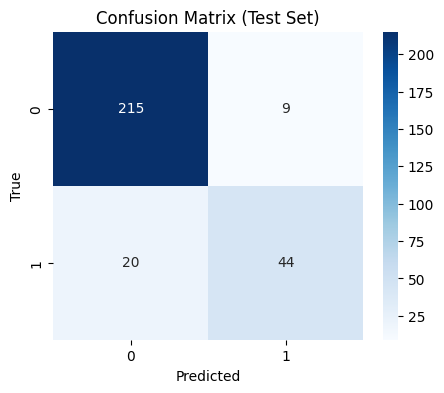

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Load full dataset with HRV features + Label
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/merged_file_all_test.csv')

# Convert to binary stress label (Label==2 → 1, else 0)
df['Label'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Drop columns that should NOT be features
non_feature_cols = ['Label']
X = df.drop(columns=non_feature_cols, errors='ignore')
y = df['Label']

# Split into train/test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42,stratify=y
)

# Train Random Forest with balanced class weights
clf = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Print classification report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['No Stress', 'Stress']))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()
# Save model
#joblib.dump(clf, 'stress_rf_binary_all_data_model.pkl')
#print("Model saved")


In [ ]:
# feature importance
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

         Feature  Gini Importance
15     HRV_MinNN         0.150020
0     HRV_MeanNN         0.135933
11   HRV_Prc20NN         0.133204
6   HRV_MedianNN         0.085613
12   HRV_Prc80NN         0.079381
16     HRV_MaxNN         0.062635
14     HRV_pNN20         0.036469
10   HRV_SDRMSSD         0.035373
2      HRV_RMSSD         0.031041
4       HRV_CVNN         0.030156
3       HRV_SDSD         0.029484
5       HRV_CVSD         0.029047
13     HRV_pNN50         0.028572
8      HRV_MCVNN         0.027821
1       HRV_SDNN         0.023696
9      HRV_IQRNN         0.022474
17       HRV_HTI         0.020862
7      HRV_MadNN         0.020687
18      HRV_TINN         0.017532


| Feature           | Meaning                                         | Stress Effect     | Non-Stress Effect | Interpretation                                    |
| ----------------- | ----------------------------------------------- | ----------------- | ----------------- | ------------------------------------------------- |
| **HRV\_MinNN**    | Minimum R-R interval                            | Decreases         | Increases         | Faster HR shortens intervals under stress         |
| **HRV\_MeanNN**   | Mean of R-R intervals                           | Decreases         | Increases         | Overall HR is faster in stress, slower in rest    |
| **HRV\_Prc20NN**  | 20th percentile of R-R intervals                | Decreases         | Increases         | Distribution shifts left in stress                |
| **HRV\_MedianNN** | Median R-R interval                             | Decreases         | Increases         | Central value of RR intervals rises in non-stress |
| **HRV\_Prc80NN**  | 80th percentile of R-R intervals                | Decreases         | Increases         | Spread contracts under stress                     |
| **HRV\_MaxNN**    | Maximum R-R interval                            | Decreases         | Increases         | Longest beat gap shortens with stress             |
| **HRV\_pNN20**    | % of successive R-R diffs >20ms                 | Decreases         | Increases         | More irregular beat intervals in non-stress       |
| **HRV\_SDRMSSD**  | Std dev of RMSSD                                | Decreases         | Increases         | HRV becomes smoother under stress                 |
| **HRV\_RMSSD**    | Root Mean Square of successive R-R diffs        | Decreases         | Increases         | Reflects vagal tone; increases with relaxation    |
| **HRV\_CVNN**     | Coefficient of Variation of NN intervals        | Decreases         | Increases         | Stress reduces variability                        |
| **HRV\_SDSD**     | Std dev of successive R-R diffs                 | Decreases         | Increases         | Smaller changes between beats under stress        |
| **HRV\_CVSD**     | RMSSD / MeanNN                                  | Decreases         | Increases         | Normalized variation falls in stress              |
| **HRV\_pNN50**    | % of R-R diffs >50ms                            | Decreases sharply | Increases sharply | Highly sensitive to stress; drops sharply         |
| **HRV\_MCVNN**    | Median Coefficient of Variation of NN intervals | Decreases         | Increases         | Robust HRV variability measure                    |
| **HRV\_SDNN**     | Std dev of all NN intervals                     | Decreases         | Increases         | Overall HRV drops with stress                     |
| **HRV\_IQRNN**    | Interquartile Range of NN intervals             | Decreases         | Increases         | Spread of heart intervals expands in non-stress   |
| **HRV\_HTI**      | HRV Triangular Index                            | Decreases         | Increases         | Lower histogram spread under stress               |
| **HRV\_MadNN**    | Median Absolute Deviation of NN intervals       | Decreases         | Increases         | Robust variability decreases in stress            |
| **HRV\_TINN**     | Baseline width of HRV histogram                 | Decreases         | Increases         | Distribution narrows under stress                 |


**3class classification on all data**

Classification Report on Test Set:

              precision    recall  f1-score   support

           1       0.73      0.92      0.82       116
           2       0.80      0.77      0.78        64
           3       0.29      0.06      0.10        34

    accuracy                           0.74       214
   macro avg       0.61      0.58      0.57       214
weighted avg       0.68      0.74      0.69       214



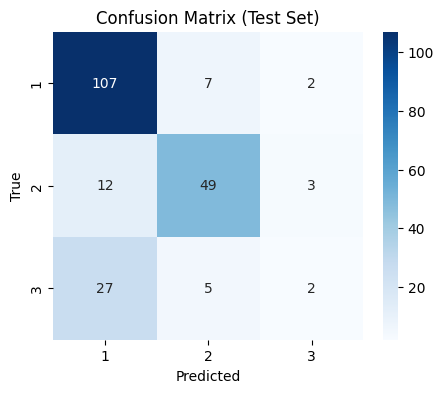

Model saved


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/merged_file_all_test.csv')

# drop label 4 becasue 3 class classification
df = df[df['Label'] != 4]

# Separate features and label
X = df.drop(columns=['Label'])
y = df['Label']

# training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest
clf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced")

# Train on training data
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation report
print("Classification Report on Test Set:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()
joblib.dump(clf, 'stress_rf__all_data_model.pkl')
print("Model saved")


**Binary classifiction using 12 subject data for training and 3 subject data as testing(Leave one group out approach)**

In [ ]:
import pandas as pd
import joblib
import neurokit2 as nk

# Loading model
model = joblib.load('/content/stress_rf_model_binary_LOGO.pkl')

#Loading 30s test ECG window
window_path = '/content/drive/MyDrive/WESAD_pkl/ECG/ECG_RAW/ECG_binary_Class/s15_30s/1/S15_window_88.csv'
df = pd.read_csv(window_path)

# ECG cleaning and feature extraction using neurokit
ecg_signal = df['ECG'].values
signals, info = nk.ecg_process(ecg_signal, sampling_rate=700)
hrv_features = nk.hrv_time(signals['ECG_R_Peaks'], sampling_rate=700, show=False)


# drop label
X = hrv_features.drop(columns=['Label'], errors='ignore')
X = X.dropna(axis=1, how='all')

prediction = model.predict(X)[0]
true_label = df['Label'].mode()[0]

# Output
print(f"Model Prediction: {prediction}")
print(f"Ground Truth Label: {true_label}")
print("Correct!" if prediction == true_label else "Incorrect.")


Model Prediction: 1
Ground Truth Label: 1
Correct!


**3class classification using 12 subject data and 3 testing data**

In [ ]:
import pandas as pd
import joblib
import neurokit2 as nk

# Loading model
model = joblib.load('/content/stress_rf_model_3class_LOGO.pkl')

#Loading 30s test ECG window
window_path = '/content/drive/MyDrive/WESAD_pkl/ECG/ECG_RAW/ECG_3_class/s15_30s/3/S15_window_49.csv'
df = pd.read_csv(window_path)

# ECG cleaning and feature extraction using neurokit
ecg_signal = df['ECG'].values
signals, info = nk.ecg_process(ecg_signal, sampling_rate=700)
hrv_features = nk.hrv_time(signals['ECG_R_Peaks'], sampling_rate=700, show=False)


# drop label
X = hrv_features.drop(columns=['Label'], errors='ignore')
X = X.dropna(axis=1, how='all')

prediction = model.predict(X)[0]
true_label = df['Label'].mode()[0]

# Output
print(f"Model Prediction: {prediction}")
print(f"Ground Truth Label: {true_label}")
print("Correct!" if prediction == true_label else "Incorrect.")


Model Prediction: 1
Ground Truth Label: 3
Incorrect.


Classification Report:
              precision    recall  f1-score   support

   No Stress       0.90      1.00      0.95        74
      Stress       1.00      0.64      0.78        22

    accuracy                           0.92        96
   macro avg       0.95      0.82      0.86        96
weighted avg       0.92      0.92      0.91        96



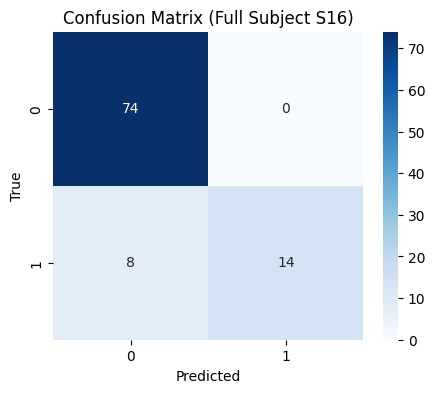

In [7]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset for unseen subject
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/hrv_features_labeled_S15.csv')

# Convert to binary stress label (Label==2 then 1, else 0)
df['Label'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and labels
X = df.drop(columns=['Label'], errors='ignore')
y = df['Label']

clf = joblib.load('/content/drive/MyDrive/WESAD_pkl/ECG/models/stress_rf_model_binary_LOGO.pkl')

y_pred = clf.predict(X)

# classification report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['No Stress', 'Stress']))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Full Subject S16)')
plt.show()


Classification Report:
              precision    recall  f1-score   support

   No Stress       1.00      0.97      0.99        75
      Stress       0.91      1.00      0.95        21

    accuracy                           0.98        96
   macro avg       0.96      0.99      0.97        96
weighted avg       0.98      0.98      0.98        96



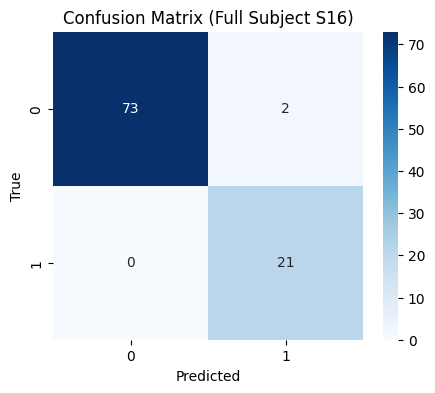

In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset for unseen subject
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/hrv_features_labeled_S16.csv')

# Convert to binary stress label (Label==2 then 1, else 0)
df['Label'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and labels
X = df.drop(columns=['Label'], errors='ignore')
y = df['Label']

clf = joblib.load('/content/drive/MyDrive/WESAD_pkl/ECG/models/stress_rf_model_binary_LOGO.pkl')

y_pred = clf.predict(X)

# classification report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['No Stress', 'Stress']))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Full Subject S16)')
plt.show()


Classification Report:
              precision    recall  f1-score   support

   No Stress       0.99      0.97      0.98        73
      Stress       0.92      0.96      0.94        24

    accuracy                           0.97        97
   macro avg       0.95      0.97      0.96        97
weighted avg       0.97      0.97      0.97        97



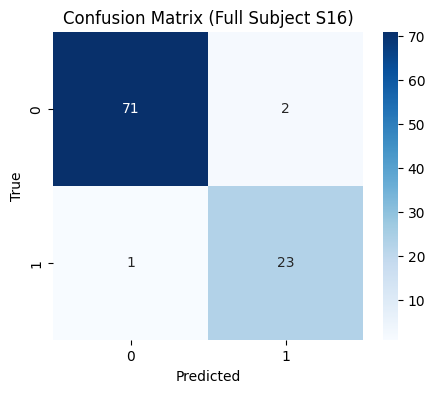

In [8]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset for unseen subject
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/hrv_features_labeled_S17.csv')

# Convert to binary stress label (Label==2 then 1, else 0)
df['Label'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and labels
X = df.drop(columns=['Label'], errors='ignore')
y = df['Label']

clf = joblib.load('/content/drive/MyDrive/WESAD_pkl/ECG/models/stress_rf_model_binary_LOGO.pkl')

y_pred = clf.predict(X)

# classification report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['No Stress', 'Stress']))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Full Subject S16)')
plt.show()
